In [ ]:
###############################################################################
### Amazon Review Senstiment Analysis

### Author: Shawn Liu / Neelay Patel
### Date: 11/6/2021
###############################################################################

In [115]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
import seaborn as sns


from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import numpy as np
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

In [ ]:
###############################################################################
### Function to process documents
###############################################################################
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

In [ ]:
###############################################################################
#   Functions to label encoding
###############################################################################
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

In [111]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [113]:
###############################################################################
### Processing text into lists
###############################################################################

#set working Directory to where class corpus is saved.
os.chdir('/content/gdrive/MyDrive/453_NLP/')


#read in class corpus csv into python
data=pd.read_csv('Coffeemaker_reviews.csv')



In [114]:
###data exploration

df = pd.DataFrame(data, columns=['Profile Name', 'Rating', 'Datetime', 'Review Text'])
df

,Profile Name,Rating,Datetime,Review Text
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
4985,NaN,NaN,NaN,NaN
4986,NaN,NaN,NaN,NaN
4987,NaN,NaN,NaN,NaN
4988,NaN,NaN,NaN,NaN


In [ ]:
####data exploration

df.isna().sum()

a-profile-name    0
Ratings           0
Date_time         0
Reviews           0
dtype: int64

In [ ]:
####create sentiment label function

#to balance the # of positive and negative reiviews, i have categorized 3 under negative bucket. 

def sent(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['Ratings'] == 1.0 or row['Ratings'] == 2.0 or row['Ratings'] == 3.0:
        val = 'Negative'
    elif row['Ratings'] == 4.0 or row['Ratings'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [ ]:
df_1 = df.dropna(subset=['Reviews', 'Date_time'])
df_1['Date_time'] = pd.to_datetime(df_1['Date_time'])
df_1.sort_values(by=['Date_time'])
df_1['sentiment'] = df_1.apply(sent, axis=1)
df_1.describe()

,Ratings
count,4990.000000
mean,3.534870
std,1.608222
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


Text(0.5, 1.0, 'Distribution of reviews by rating')

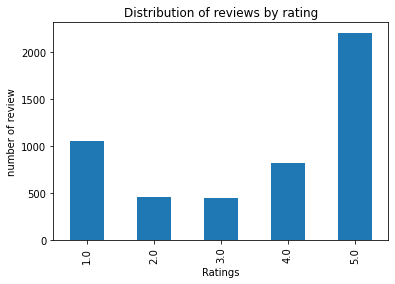

In [ ]:
####explore distribution of sentiment of reviews

df_1.groupby('Ratings').size().plot.bar()
plt.ylabel("number of review")
plt.title("Distribution of reviews by rating")


Text(0.5, 1.0, 'Distribution of reviews by sentiment')

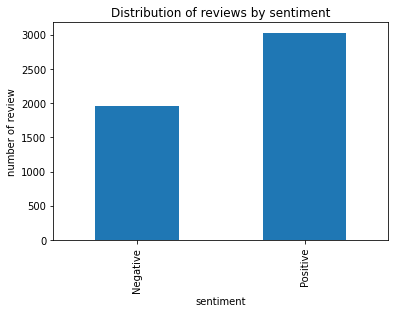

In [ ]:
df_1.groupby('sentiment').size().plot.bar()
plt.ylabel("number of review")
plt.title("Distribution of reviews by sentiment")

In [ ]:
#explore the lenghth of reviews

df["review_length"] = df_1["Reviews"].apply(len)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

59.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

27.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

54.6% of the points cannot be placed; you may w

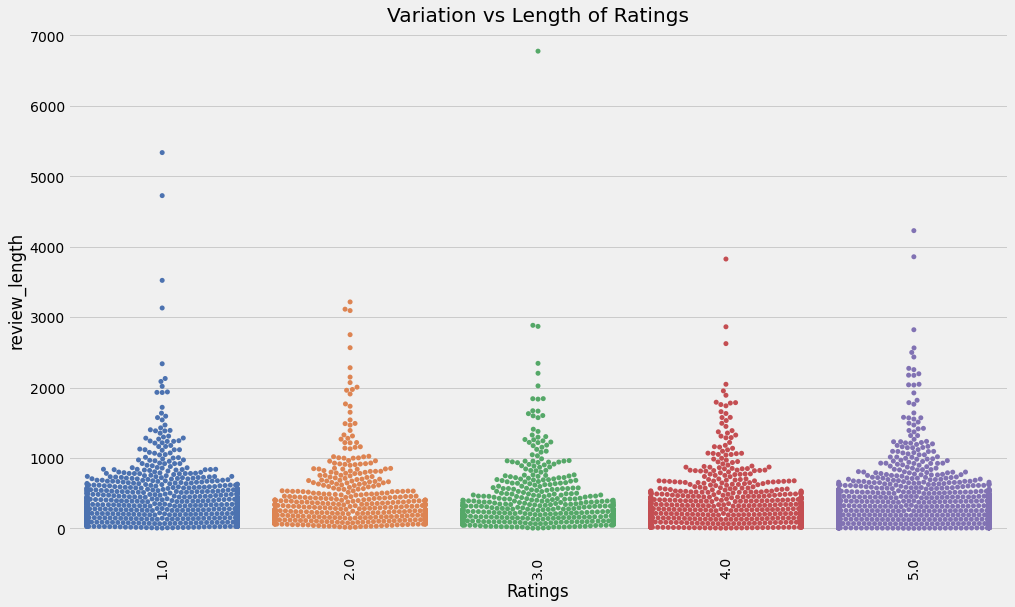

In [ ]:
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('fivethirtyeight')

sns.swarmplot(df_1['Ratings'], data['review_length'], palette = 'deep')
plt.title("Variation vs Length of Ratings")
plt.xticks(rotation = 90)
plt.show()

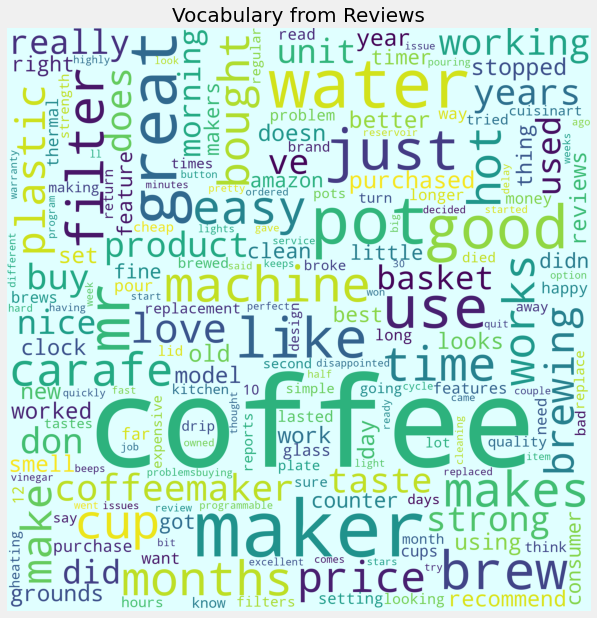

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df_1.Reviews)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()

In [ ]:
#@title
#create empty list to store text documents titles
ratings=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(df_1)):
    temp_text=df_1['Ratings'].iloc[i]
    ratings.append(temp_text)

senti = []
for i in range(0,len(df_1)):
    temp_text=df_1['sentiment'].iloc[i]
    senti.append(temp_text)

#create empty list to store text documents
review_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(df_1)):
    temp_text=df_1['Reviews'].iloc[i]
    review_body.append(temp_text)

#Note: the text_body is the unprocessed list of documents read directly from
#the csv.
    
#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in review_body:
    text=clean_doc(i)
    processed_text.append(text)

#Note: the processed_text is the PROCESSED list of documents read directly form 
#the csv.  Note the list of words is separated by commas.

###note that there is empty list, which will return error "list index is out of range"
processed_text_new = [i for i in processed_text if i != []]
empty_index = [id for id, text in enumerate(processed_text) if text == []]
ratings_new = []
sentiment_new = []
for i in range(len(processed_text)):
    if i not in empty_index:
        ratings_new.append(ratings[i])
        sentiment_new.append(senti[i])                                          


#stitch back together individual words to reform body of text
final_processed_text=[]

for i, review in enumerate(processed_text_new):
    temp_DSI=review[0]
    if len(review)>1:
        for k in range(1,len(review)):
            temp_DSI=temp_DSI+' '+review[k]
    final_processed_text.append(temp_DSI)
    
#Note: We stitched the processed text together so the TFIDF vectorizer can work.
#Final section of code has 3 lists used.  2 of which are used for further processing.
#(1) text_body - unused, (2) processed_text (used in W2V), 
#(3) final_processed_text (used in TFIDF), and (4) DSI titles (used in TFIDF Matrix)

In [ ]:
#@title
dic_1 = {'rating': ratings_new, 'sentiment': sentiment_new, 'reviews':processed_text_new}
df_2 = pd.DataFrame(dic_1, columns =['rating', 'sentiment', 'reviews'])
df_2

,rating,sentiment,reviews
0,3.0,Negative,"[enjoy, coffee, enjoy, smelling, brewing, abse..."
1,1.0,Negative,"[tried, tried, coffee, awful, sprayer, sprays,..."
2,2.0,Negative,"[opinion, product, mixed, coffee, maker, looks..."
3,3.0,Negative,"[bought, product, months, loved, coffee, taste..."
4,1.0,Negative,"[purchased, cheap, coffee, maker, finally, giv..."
...,...,...,...
4911,5.0,Positive,"[coffee, maker, friendly, efficient, attractiv..."
4912,5.0,Positive,"[happy, consumer, reports, ratings, great, pri..."
4913,5.0,Positive,"[dollars, great, product, steal, price, places..."
4914,5.0,Positive,"[replacement, prevous, coffee, machine, appear..."


In [ ]:
#@title
df_pos = df_2[df_2['sentiment'] == 'Positive']
df_neg = df_2[df_2['sentiment'] == 'Negative']

#stitch all positive/negative key words together
reviews_pos = df_pos['reviews'].sum()
reviews_neg = df_neg['reviews'].sum()

len(reviews_pos)


50444

In [ ]:
#@title
def stitch(list):
    temp_DSI=list[0]
    for k in range(1,len(list)):
        temp_DSI=temp_DSI+' '+list[k]
    return temp_DSI

In [ ]:
#@title
senti_list = []
senti_list.append(stitch(reviews_pos))
senti_list.append(stitch(reviews_neg))

len(senti_list[0])

380951

In [ ]:
sentiment = ['positive', 'negative']

In [ ]:
###############################################################################
### Sklearn TFIDF 
###############################################################################
#note the ngram_range will allow you to include multiple words within the TFIDF matrix
#Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(3,4))
#(1,1)represent the window to extract words to each other, whichi going to create a lot more columns, and create a lot of "0" sparse

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.
def tfidf_trans(l):
    TFIDF_matrix = Tfidf.fit_transform(l)     

#creating datafram from TFIDF Matrix
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names())
    
    return matrix

In [ ]:
matrix_pos = tfidf_trans([senti_list[0]])
matrix_neg = tfidf_trans([senti_list[1]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
#@title
###############################################################################
### Explore TFIDF Values
###############################################################################

df_pos =pd.DataFrame(matrix_pos,index=[0]).transpose()

df_pos.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(df_pos, 25)
Q3=np.percentile(df_pos, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)


#words that exceed the Q3+IQR*1.5
outlier_list=df_pos[df_pos['TFIDF']>=outlier]

In [ ]:
df_pos.sort_values('TFIDF',ascending=False)[:100]

,TFIDF
makes great coffee,0.391110
great coffee maker,0.351110
coffee maker coffee,0.148889
coffee maker great,0.124444
coffee coffee maker,0.113333
...,...
great coffee machine,0.020000
consumer reports rated,0.020000
coffee programmable coffeemaker chrome,0.020000
coffee maker money,0.020000


In [ ]:
df_neg =pd.DataFrame(matrix_neg,index=[0]).transpose()
df_neg.columns=['TFIDF']
df_neg.sort_values('TFIDF',ascending=False)[:10]

,TFIDF
stopped working months,0.144329
coffee maker coffee,0.135669
coffee coffee maker,0.112576
coffee maker months,0.112576
coffee maker worked,0.095257
bought coffee maker,0.095257
purchased coffee maker,0.095257
months stopped working,0.077937
coffee maker lasted,0.072164
worked great months,0.063505


**Testify the best ngram_range parameters to extract features from corpus**

In [ ]:
#GridSearchCV to testify parameters of n-gram for feature extraction
#Don't run unless needed for expanding parameter optimization

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

review_corpus = []
for i, row in df.iterrows():
  review_corpus.append(row['Reviews'])

x = np.array(review_corpus)
y = df["Ratings"].apply(lambda x: 1 if x > 2 else 0) #binary, only consider postive and negative buckets

rfc_pipe = Pipeline(
    [('cv', TfidfVectorizer()),
      ('abs', MaxAbsScaler()),
      ('rfc', RandomForestClassifier())
     ]
)

params = {'cv__ngram_range': [(1,1), (1,2), (2,2), (1,3), (3,3)]}

gs_rfc = GridSearchCV(rfc_pipe, param_grid = params, scoring='accuracy', cv=5)

gs_rfc.fit(x, y)

print(gs_rfc.best_params_)
print(gs_rfc.score(x, y))

{'cv__ngram_range': (1, 2)}
0.9995991983967936


In [ ]:
# dict to track the models' performance
performance = {}

## Model 1 - TFIDF Vectorizer + RandomForestClassfier(Traditional ML)

0.8623914495657983


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



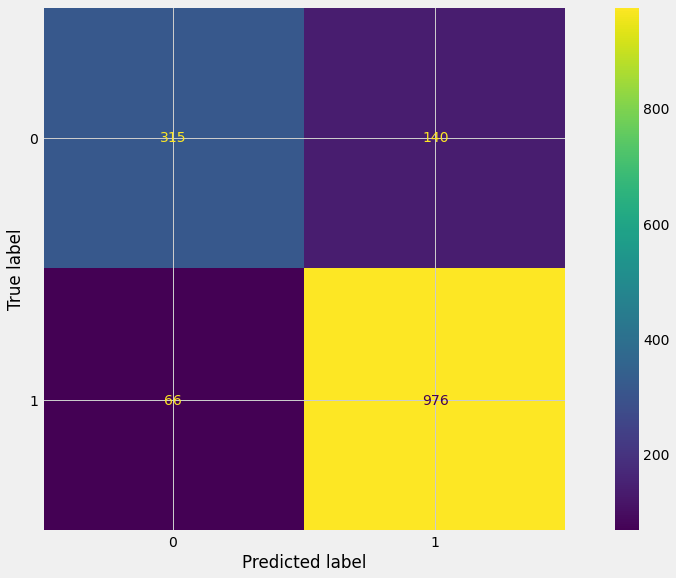

In [ ]:
###algorithm 1 - RandomForestClassifier
##convert rating to positive/negative binary label

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix


cv_1 = TfidfVectorizer(ngram_range=(1,2), max_features=3000)

x_1 = cv.fit_transform(review_corpus).toarray()
y_bi = df["Ratings"].apply(lambda x: 1 if x > 2 else 0)

x_train, x_test, y_bi_train, y_bi_test = train_test_split(x_1, y_bi, test_size = 0.3, random_state = 15)

rfc_1 = RandomForestClassifier()
rfc_1.fit(x_train, y_bi_train)

y_bi_pred = rfc_1.predict(x_test)

cm_1 = confusion_matrix(y_bi_test, y_bi_pred)

score1 = metrics.accuracy_score(y_bi_test, y_bi_pred)
print(score1)

SVC(random_state=0)
plot_confusion_matrix(rfc_1, x_test, y_bi_test)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

accuracy = accuracy_score(y_bi_test, y_bi_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_bi_test, y_bi_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_bi_test, y_bi_pred)
print('Recall: %f' % recall)

Accuracy: 0.862391
Precision: 0.874552
Recall: 0.936660


In [ ]:

performance['Rf+TfidfVectorizer'] = [accuracy, precision, recall]

## Model 2 - TFIDFvectorizer + Logistic Classification

0.8537074148296593


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



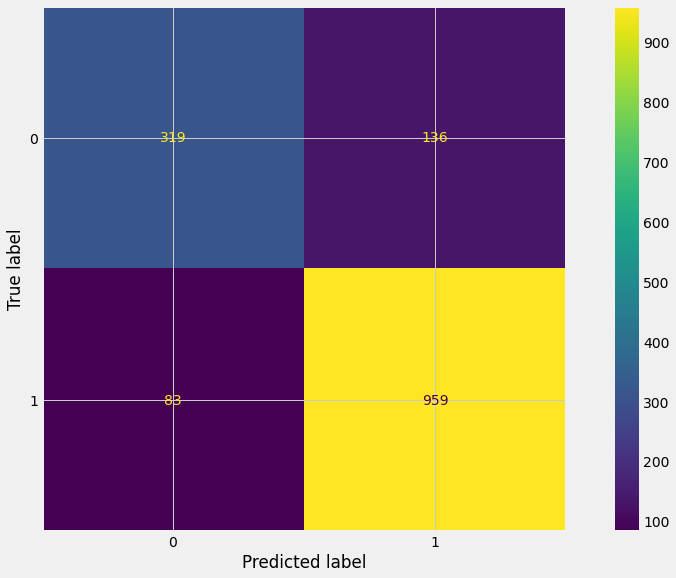

In [ ]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression()
lgr.fit(x_train, y_bi_train)

y_lr_pred = lgr.predict(x_test)

cm_2 = confusion_matrix(y_bi_test, y_lr_pred)

score2 = metrics.accuracy_score(y_bi_test, y_lr_pred)
print(score2)

SVC(random_state=0)
plot_confusion_matrix(lgr, x_test, y_bi_test)
plt.show()

In [ ]:
accuracy = accuracy_score(y_bi_test, y_lr_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_bi_test, y_lr_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_bi_test, y_lr_pred)
print('Recall: %f' % recall)

Accuracy: 0.853707
Precision: 0.875799
Recall: 0.920345


In [ ]:
performance['Lr+TfidfVectorizer'] = [accuracy, precision, recall]

## Model 3 - TFIDFvectorizer + Neural Networks(LSTM)

In [ ]:
##Data preparation for LSTM model

# Generate a cleaned reviews array from original review texts
review_cleans = [clean_doc(doc) for doc in df["Reviews"]];
sentences = [' '.join(r) for r in review_cleans ]

len(sentences)

4990

In [ ]:
print(sentences[7])

product control panel little complicated necessary unusual features intuitive although shouldnt really manual conspros purchase larger filters smaller filters coffee designed forget coffee might taste water evaporates enough crack carafe cause strength options havent tried always little coffee stronger feature could money programmable timed start essential aroma brewing coffeecons model comes water filter grinds basket filters minerals coming showerhead spout manual recommends filter changed monthly never problem water although water filter kitchen unless really water might suggest totally frivolous feature designed store filter replacements since recommended filter changed every brews monthly fortunately coffee maker require coffee without using filter built sensor determines whether using glass carafe provided thermal carafe imagine metal thermal carafe triggers magnetic switch prevents warming going actually bought unhappy coffee thermal carafe using since difficult clean glass coff

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

text_sequences = np.array(tokenizer.texts_to_sequences(sentences))
sequence_dict = tokenizer.word_index
word_dict = dict((num, val) for (val, num) in sequence_dict.items())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
print(text_sequences)

[list([318, 1, 318, 1141, 16, 2597, 40, 3545, 1, 16, 653, 328, 2597, 1, 22, 204, 71, 96, 20, 97, 1010, 1, 75, 267, 18, 6, 126, 1783, 3546, 1784, 12, 224, 2598, 672, 39, 13, 184, 284, 117, 3, 284, 443, 174, 3, 284, 83, 2098, 1567, 896, 71, 897, 1324, 3547, 1, 425, 100, 3, 896, 23, 254, 131, 818, 47, 1227, 265, 37, 857, 691, 329, 266, 556, 653, 499, 40, 22, 3548, 44, 613, 40, 1568, 3, 308, 59, 1568, 340, 3549, 557, 287, 3550, 171, 102, 637, 2599, 896, 105, 285, 3551, 163, 174, 1, 1011, 76, 1439, 858, 3552, 45, 3553, 122, 1440, 614, 3554, 898, 3555, 155, 35, 3556, 2600, 795, 2099, 1142, 2100, 2601, 3557, 2101, 14, 1325, 3558, 1077, 19, 568, 3559, 2602, 1012, 1785, 1142, 1077, 152, 819, 175, 196, 161, 135, 1013, 1786, 3560, 2603, 35, 1787, 225, 72, 1143, 3561, 119, 1788, 3562, 22, 521, 59, 257, 54, 584, 3563])
 list([77, 77, 1, 499, 1441, 1442, 1078, 24, 569, 1, 5, 1326, 569, 33, 1, 5, 570, 1, 451, 70, 1, 409, 1, 3, 571, 558, 24, 1, 33, 157, 1, 2, 237, 19, 522, 44, 444, 9, 92, 56, 10, 1, 1

In [ ]:
print(word_dict)

{1: 'coffee', 2: 'maker', 3: 'water', 4: 'great', 5: 'filter', 6: 'would', 7: 'machine', 8: 'makes', 9: 'months', 10: 'carafe', 11: 'works', 12: 'bought', 13: 'price', 14: 'plastic', 15: 'coffeemaker', 16: 'brewing', 17: 'working', 18: 'years', 19: 'first', 20: 'strong', 21: 'product', 22: 'taste', 23: 'really', 24: 'basket', 25: 'purchased', 26: 'morning', 27: 'still', 28: 'every', 29: 'stopped', 30: 'doesnt', 31: 'better', 32: 'using', 33: 'grounds', 34: 'model', 35: 'worked', 36: 'looks', 37: 'another', 38: 'recommend', 39: 'reviews', 40: 'smell', 41: 'clock', 42: 'clean', 43: 'didnt', 44: 'thing', 45: 'right', 46: 'counter', 47: 'little', 48: 'makers', 49: 'never', 50: 'timer', 51: 'feature', 52: 'thermal', 53: 'could', 54: 'purchase', 55: 'consumer', 56: 'glass', 57: 'amazon', 58: 'brews', 59: 'problem', 60: 'happy', 61: 'since', 62: 'money', 63: 'lasted', 64: 'features', 65: 'without', 66: 'longer', 67: 'setting', 68: 'replacement', 69: 'looking', 70: 'times', 71: 'brewed', 72: '

In [ ]:
reviews_encoded = [];
for i,review in enumerate(review_cleans):
    reviews_encoded.append([sequence_dict[x] for x in review]);


x_3 = pad_sequences(reviews_encoded)
y_3 = np.array([[0,1] if y==0 else [1,0] for y in y_bi])

x_3_train, x_3_test, y_3_train, y_3_test = train_test_split(x_3, y_3, test_size = 0.3, random_state = 15)

print(y_3.shape)

(4990, 2)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import eval
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers.embeddings import Embedding


model = Sequential()
model.add(Embedding(len(word_dict)+1, 64))
#adding a LSTM layer of dim 1--
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(150, return_sequences=False))
#adding a dense layer with activation function of relu
model.add(Dense(100, activation='relu'))#best 50,relu
#adding the final output activation with activation function of softmax
model.add(Dense(2, activation='sigmoid'))
print(model.summary())
optimizer = Adam(learning_rate=0.0001, decay=0.0001)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model and run it for 5 epochs
model.fit(x_3_train, y_3_train, batch_size=20, epochs=10, validation_data=(x_3_test, y_3_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          535424    
                                                                 
 lstm (LSTM)                 (None, None, 150)         129000    
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 100)               15100     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 860,326
Trainable params: 860,326
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
175/175 [=========================

In [ ]:
score3 = model.evaluate(x_3_test, y_3_test)
print("Test accuracy: %0.4f%%" % (score3[1]*100))

47/47 [==============================] - 16s 348ms/step - loss: 0.5500 - accuracy: 0.8283
Test accuracy: 82.8323%


In [ ]:
y_3_pred = model.predict(x_3_test)

y_3_test_s = pd.DataFrame(y_3_test).iloc[:,0]
y_3_pred_s = pd.DataFrame(y_3_pred).iloc[:,0].apply(lambda x: 1 if x > 0.5 else 0)
cm_3 = confusion_matrix(y_3_test_s, y_3_pred_s)

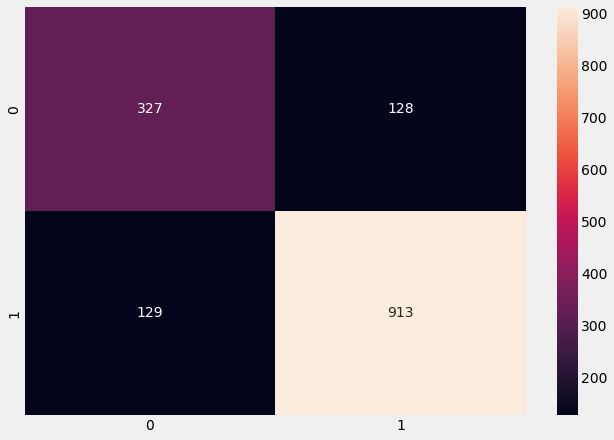

In [ ]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm_3, annot=True, fmt='d')

In [ ]:
accuracy = accuracy_score(y_bi_test, y_3_pred_s)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_bi_test, y_3_pred_s)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_bi_test, y_3_pred_s)
print('Recall: %f' % recall)

Accuracy: 0.828323
Precision: 0.877041
Recall: 0.876200


In [ ]:
performance['LSTM'] = [accuracy, precision, recall]

In [ ]:
###from the result of LSTM model, we can tell that the model has performed better on FP rate by increasing the FN. 

In [ ]:
print(y_3_pred)

## Model 4 - TFIDFvectorizer + Deep Learning (CNN)

In [ ]:
MAX_FEATURES = 3000

In [ ]:
from tensorflow.python.keras import models, layers, optimizers
import tensorflow


model = Sequential()
model.add(Embedding(len(word_dict)+1, 64))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))
print(model.summary())
optimizer = Adam(learning_rate=0.0001, decay=0.0001)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model and run it for 10 epochs
model.fit(x_3_train, y_3_train, batch_size=20, epochs=10, validation_data=(x_3_test, y_3_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          535424    
                                                                 
 module_wrapper (ModuleWrapp  (None, None, 64)         12352     
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, None, 64)         256       
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, None, 64)         0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, None, 64)         20544     
 pper)                                                

In [ ]:
y_4_pred = model.predict(x_3_test)

y_4_test_s = pd.DataFrame(y_3_test).iloc[:,0]
y_4_pred_s = pd.DataFrame(y_4_pred).iloc[:,0].apply(lambda x: 1 if x > 0.5 else 0)
cm_4 = confusion_matrix(y_4_test_s, y_4_pred_s)

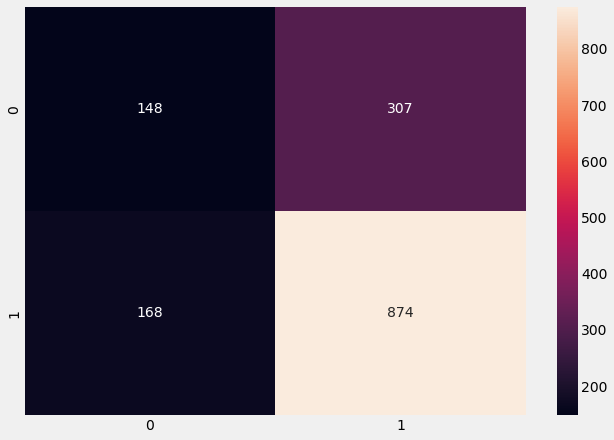

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(cm_4, annot=True, fmt='d')

In [ ]:
score4 = model.evaluate(x_3_test, y_3_test)
print("Test accuracy: %0.4f%%" % (score4[1]*100))

47/47 [==============================] - 1s 23ms/step - loss: 0.8837 - accuracy: 0.6820
Test accuracy: 68.2031%


In [ ]:
accuracy = accuracy_score(y_bi_test, y_4_pred_s)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_bi_test, y_4_pred_s)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_bi_test, y_4_pred_s)
print('Recall: %f' % recall)

Accuracy: 0.682699
Precision: 0.740051
Recall: 0.838772


In [ ]:
performance['CNN'] = [accuracy, precision, recall]

## Model 5 - Cutomized spaCY Vectorizer  + RandomForestClassfier(Traditional ML)

In [ ]:
#### feature extraction - spaCy #####
#### (Hypothesis) As spaCy uses the latest and best algorithms, its performance is usually good as compared to NLTK. 
#### As we can see below, in word tokenization and POS-tagging spaCy performs better, but in sentence tokenization, NLTK outperforms spaCy. 
#### Its poor performance in sentence tokenization is a result of differing approaches: NLTK attempts to split the text into sentences. 
####In contrast, spaCy constructs a syntactic tree for each sentence, a more robust method that yields much more information about the text.

#### the reason to try this feature extraction is because most of reviews is short with a fewer words, as shown by the distribution graph of reivew length.
#### we expected the word token, especially ones that carries more sentiment information, will play more important roles probably than sentenses. 

!pip install -U spacy

!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 6.0 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 39.0 MB/s 
     |████████████████████████████████| 451 kB 47.8 MB/s 
     |████████████████████████████████| 628 kB 71.9 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 10.1 MB 40.7 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 777.4 

[https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk] more information about spaCy library

In [ ]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin

# Create our list of punctuation marks
# punctuations = string.punctuation

# # Create our list of stopwords
# nlp = spacy.load('en_core_web_sm')
# stop_words = spacy.lang.en.stop_words.STOP_WORDS

# # Load English tokenizer, tagger, parser, NER and word vectors
# parser = English()


# # Creating tokenizer function
# def spacy_tokenizer(sentence):
#     # Creating our token object, which is used to create documents with linguistic annotations.
#     mytokens = parser(sentence)

#     # Lemmatizing each token and converting each token into lowercase
#     mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

#     # Removing stop words
#     mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

#     # return preprocessed list of tokens
#     return mytokens

In [ ]:
#custom transformer class to be used just as Scikit-learn's TfidfVectorizer or CountVectorizer that we saw earlier.
from sklearn.base import BaseEstimator, TransformerMixin

class WordVectorTransformer(TransformerMixin,BaseEstimator):
    def __init__(self, model="en_core_web_lg"):
        self.model = model

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        nlp = spacy.load(self.model)
        return np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in X])

In [ ]:
#slit the data
x_5 = df['Reviews']
y_bi = df["Ratings"].apply(lambda x: 1 if x > 2 else 0)

x_5_train, x_5_test, y_bi_train, y_bi_test = train_test_split(x_5, y_bi, test_size = 0.3, random_state = 15)

print(x_5_train.shape, x_5_test.shape)

(3493,) (1497,)


In [ ]:
##training the model with self defined vectorizer based on spaCY, and RandomforestClassifier as classificifier)

text_clf = Pipeline([
            ('vect', WordVectorTransformer()),
            ('rfc', RandomForestClassifier()),
            ])

text_clf.fit(x_5_train, y_bi_train)

y_bi_pred = text_clf.predict(x_5_test)

cm_5 = confusion_matrix(y_bi_test, y_bi_pred)

score5=metrics.accuracy_score(y_bi_test, y_bi_pred)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



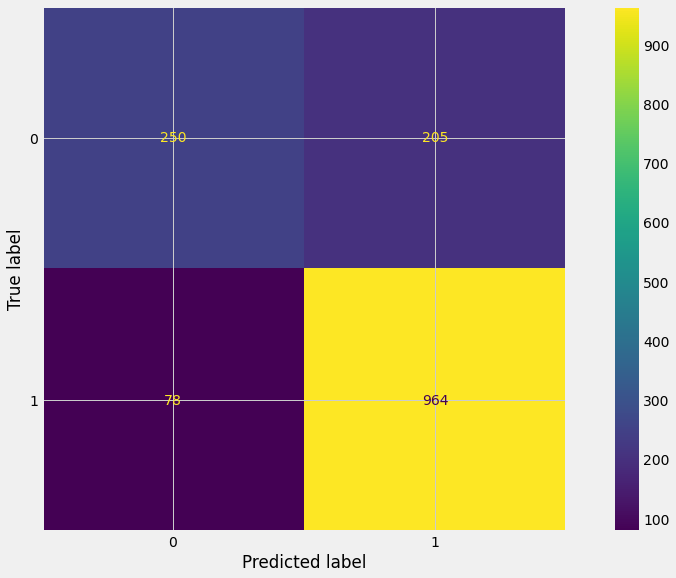

In [ ]:
###plot the confusion matrix
SVC(random_state=0)
plot_confusion_matrix(text_clf, x_5_test, y_bi_test)
plt.show()

In [ ]:
### explore why there is higher FP (False Positive)
df_FP = pd.DataFrame({'actual':y_bi_test, 'predict':y_bi_pred}, columns=['actual', 'predict'])
FP_index = df_FP[df_FP['actual'] < df_FP['predict']].index

FP_reviews = df.loc[FP_index][['Reviews', 'Ratings']]

In [ ]:
print(FP_reviews.iloc[2]['Reviews'])
print(FP_reviews.iloc[2]['Ratings'])

####finding
#the user provides revies with both positive and negative words, kinda confused the model. the user mentions the problem, but at the end, he said he and his wife likes the brand

As many others stated the Strong setting cycle does not work.  It runs for a few seconds then the three chimes sound and the light goes out.  Brewing does continue.  The manual states that the Strong cycle will stay on for future brews but this one returns to regular.  I called Mr. Coffee the woman told me to return it and stated that she had heard this complain before.  I would think that a program could be devised by the manufacture to test all the cycles and save these returns.  I liked the concept of this machine and had even bought the thermal container because my wife makes her coffee early and I make mine later and pour it into a thermal carafe.  Rather than try again we went back to the Cuisinart model we had before.
1.0


In [ ]:
print(FP_reviews.iloc[10]['Reviews'])
print(FP_reviews.iloc[10]['Ratings'])

#same as above, there are mix of postive and negative tokens parsed out of the review text. 

Coffee never was very hot, even fresh brewed. The coffee pot worked for almost 6 months.  I would not recommend this model.Easy to set and use.
2.0


In [ ]:
accuracy = accuracy_score(y_bi_test, y_bi_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_bi_test, y_bi_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_bi_test, y_bi_pred)
print('Recall: %f' % recall)

Accuracy: 0.810955
Precision: 0.824636
Recall: 0.925144


In [ ]:
performance['Rf+spaCy tokenizer'] = [accuracy, precision, recall]

Result Comparison

In [ ]:
perf_df = pd.DataFrame.from_dict(performance, orient='index', columns=["Test_Accuracy", "Test_Precision", "Test_Recall"])

perf_df

,Test_Accuracy,Test_Precision,Test_Recall
Rf+TfidfVectorizer,0.862391,0.874552,0.936660
Lr+TfidfVectorizer,0.853707,0.875799,0.920345
LSTM,0.828323,0.877041,0.876200
CNN,0.682699,0.740051,0.838772
Rf+spaCy tokenizer,0.810955,0.824636,0.925144


<Figure size 864x144 with 0 Axes>

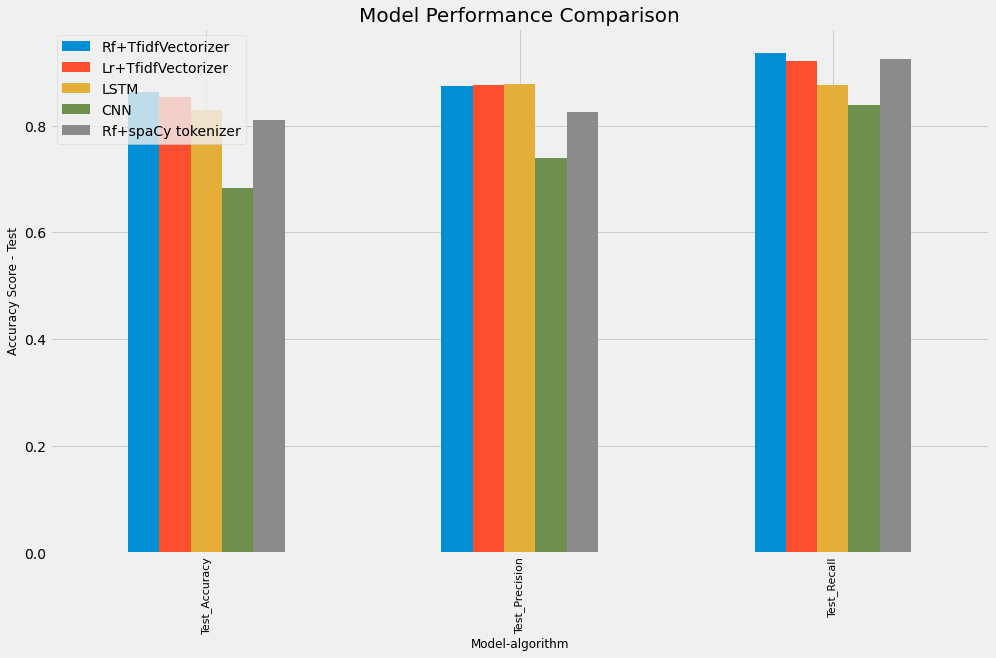

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,2))
perf_df.transpose().plot.bar()

plt.xlabel("Model-algorithm",fontsize=12)
plt.ylabel("Accuracy Score - Test", fontsize=12)
plt.title("Model Performance Comparison",fontsize=20)
plt.xticks(fontsize=11)
plt.show()